# Dataset Campur

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from google.colab import drive
import random


In [ ]:
# Mount Google Drive (uncomment jika diperlukan untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001

In [ ]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [ ]:
# Konfigurasi path data
DATA_DIR = '/content/drive/MyDrive/TA/dtcpr'  # direktori utama dataset
KARIES_DIR = os.path.join(DATA_DIR, 'processed/karies')  # direktori gambar karies
SEHAT_DIR = os.path.join(DATA_DIR, 'processed/sehat')   # direktori gambar sehat
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')  # direktori hasil preprocessing

In [ ]:
# ===== AWAL PEMERIKSAAN DATA =====
# Memeriksa jumlah gambar di setiap folder
jumlah_karies = len(os.listdir(KARIES_DIR))
jumlah_sehat = len(os.listdir(SEHAT_DIR))

print(f"Jumlah gambar karies: {jumlah_karies}")
print(f"Jumlah gambar sehat: {jumlah_sehat}")

Jumlah gambar karies: 459
Jumlah gambar sehat: 702


#Preprocessing Gambar

In [ ]:
def preprocess_image(img_path, output_path=None, denoise=True, clahe=True, save=False):
    """
    Fungsi untuk preprocessing gambar panoramik gigi

    Parameters:
    - img_path: Path ke gambar input
    - output_path: Path untuk menyimpan gambar hasil preprocessing (opsional)
    - denoise: Apakah menerapkan denoising
    - clahe: Apakah menerapkan Contrast Limited Adaptive Histogram Equalization
    - save: Apakah menyimpan hasil preprocessing

    Returns:
    - img_processed: Gambar yang telah diproses
    """
    # Baca gambar
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Tidak dapat membaca gambar dari {img_path}")
        return None

    # Konversi ke grayscale jika gambar berwarna
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Menerapkan denoising untuk mengurangi noise
    if denoise:
        img_gray = cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

    # Menerapkan CLAHE untuk meningkatkan kontras
    if clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_gray)
    else:
        img_processed = img_gray

    # Menyimpan hasil preprocessing jika diperlukan
    if save and output_path:
        cv2.imwrite(output_path, img_processed)

    return img_processed

In [ ]:
# Fungsi untuk preprocessing batch gambar (dapat dijalankan secara opsional)
def batch_preprocess(input_dir, output_dir):
    """
    Memproses semua gambar dalam direktori dan menyimpan hasil
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            preprocess_image(input_path, output_path, save=True)
            print(f"Preprocessed: {file}")


In [ ]:
# CATATAN: Uncomment baris di bawah jika ingin melakukan preprocessing manual
batch_preprocess(KARIES_DIR, os.path.join(PROCESSED_DIR, 'processed_karies'))
batch_preprocess(SEHAT_DIR, os.path.join(PROCESSED_DIR, 'processed_sehat'))

Preprocessed: 20250507_145913.jpg
Preprocessed: 161.jpg
Preprocessed: 436.jpg
Preprocessed: 354.jpg
Preprocessed: 182.jpg
Preprocessed: 278.jpg
Preprocessed: 408.jpg
Preprocessed: 13.jpg
Preprocessed: 476.jpg
Preprocessed: 515.jpg
Preprocessed: 579.jpg
Preprocessed: 522.jpg
Preprocessed: 173.jpg
Preprocessed: 384.jpg
Preprocessed: 434.jpg
Preprocessed: 297.jpg
Preprocessed: 43.jpg
Preprocessed: 115.jpg
Preprocessed: 584.jpg
Preprocessed: 6.jpg
Preprocessed: 20250507_153128.jpg
Preprocessed: 551.jpg
Preprocessed: 572.jpg
Preprocessed: 375.jpg
Preprocessed: 192.jpg
Preprocessed: 20250507_153334.jpg
Preprocessed: 335.jpg
Preprocessed: 273.jpg
Preprocessed: 327.jpg
Preprocessed: 191.jpg
Preprocessed: 556.jpg
Preprocessed: 489.jpg
Preprocessed: 292.jpg
Preprocessed: 235.jpg
Preprocessed: 225.jpg
Preprocessed: 308.jpg
Preprocessed: 211.jpg
Preprocessed: 402.jpg
Preprocessed: 20250507_154131.jpg
Preprocessed: 20250507_154117.jpg
Preprocessed: 506.jpg
Preprocessed: 323.jpg
Preprocessed: 202505

#Preprocessing Data

In [ ]:
# ===== BAGIAN PRE-PROCESSING DATA =====
# Membuat generator data dengan augmentasi untuk data training
# Preprocessing meliputi:
# 1. Rescaling - Normalisasi nilai piksel dari 0-255 menjadi 0-1
# 2. Augmentasi data - Meningkatkan variasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2,  # 20% data untuk validasi
    rotation_range=20,  # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Refleksi horizontal
    fill_mode='nearest',  # Strategi mengisi piksel baru
    # brightness_range=[0.8, 1.2]  # Variasi kecerahan (opsional untuk menangani kontras berbeda)
)


In [ ]:
# Generator untuk data validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2  # 20% data untuk validasi
)

In [ ]:
# Memuat data dan menerapkan preprocessing
# target_size - Mengubah ukuran semua gambar menjadi 224x224 piksel (preprocessing ukuran)
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasi biner: karies atau sehat
    subset='training',
    shuffle=True,  # Mengacak data untuk training
    seed=42
)

# Memuat data validasi
validation_generator = validation_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Tidak mengacak data validasi
    seed=42
)


Found 930 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


# Building Model

In [ ]:
# Membangun model CNN
model = models.Sequential([
    # Layer konvolusi pertama
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi kedua
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi ketiga
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi keempat
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer flatten untuk mengubah menjadi format 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Layer output
    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [ ]:
# Menyimpan model terbaik
checkpoint_filepath = '/content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5354 - loss: 0.8901 
Epoch 1: val_accuracy improved from -inf to 0.60606, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 564s 19s/step - accuracy: 0.5358 - loss: 0.8900 - val_accuracy: 0.6061 - val_loss: 0.6875
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5369 - loss: 0.8806
Epoch 2: val_accuracy did not improve from 0.60606
30/30 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.5374 - loss: 0.8803 - val_accuracy: 0.6061 - val_loss: 0.6776
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5321 - loss: 0.8714
Epoch 3: val_accuracy did not improve from 0.60606
30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.5330 - loss: 0.8700 - val_accuracy: 0.6061 - val_loss: 0.6749
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5534 - loss: 0.8567
Epoch 4: val_accuracy did not improve from 0.60606
30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.5535 - loss: 0.8560 - val_accuracy: 0.6061 - val_loss: 0.6788
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5632 - loss: 0.8026
Epoch 5: val_accuracy did not improve from 0.60606

30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.5929 - loss: 0.7498 - val_accuracy: 0.6234 - val_loss: 0.6317
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6204 - loss: 0.7259
Epoch 11: val_accuracy did not improve from 0.62338
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.6209 - loss: 0.7253 - val_accuracy: 0.6061 - val_loss: 0.6359
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6218 - loss: 0.7106
Epoch 12: val_accuracy did not improve from 0.62338
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.6216 - loss: 0.7108 - val_accuracy: 0.6234 - val_loss: 0.6186
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6049 - loss: 0.7285
Epoch 13: val_accuracy improved from 0.62338 to 0.62771, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.6048 - loss: 0.7282 - val_accuracy: 0.6277 - val_loss: 0.6533
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6302 - loss: 0.6823
Epoch 14: val_accuracy improved from 0.62771 to 0.70996, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.6295 - loss: 0.6835 - val_accuracy: 0.7100 - val_loss: 0.5802
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5953 - loss: 0.7230
Epoch 15: val_accuracy did not improve from 0.70996
30/30 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.5953 - loss: 0.7233 - val_accuracy: 0.7100 - val_loss: 0.5888
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6219 - loss: 0.6828
Epoch 16: val_accuracy improved from 0.70996 to 0.71429, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.6214 - loss: 0.6836 - val_accuracy: 0.7143 - val_loss: 0.5902
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6426 - loss: 0.6876
Epoch 17: val_accuracy did not improve from 0.71429
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6424 - loss: 0.6878 - val_accuracy: 0.6883 - val_loss: 0.6057
Epoch 18/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5961 - loss: 0.7536
Epoch 18: val_accuracy improved from 0.71429 to 0.72294, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.5961 - loss: 0.7529 - val_accuracy: 0.7229 - val_loss: 0.5580
Epoch 19/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6237 - loss: 0.6763
Epoch 19: val_accuracy did not improve from 0.72294
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6241 - loss: 0.6761 - val_accuracy: 0.6970 - val_loss: 0.5949
Epoch 20/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6351 - loss: 0.6667
Epoch 20: val_accuracy improved from 0.72294 to 0.77489, saving model to /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6344 - loss: 0.6682 - val_accuracy: 0.7749 - val_loss: 0.5590
Epoch 21/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6310 - loss: 0.6718
Epoch 21: val_accuracy did not improve from 0.77489
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6308 - loss: 0.6724 - val_accuracy: 0.7403 - val_loss: 0.5458
Epoch 22/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6197 - loss: 0.6622
Epoch 22: val_accuracy did not improve from 0.77489
30/30 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.6201 - loss: 0.6625 - val_accuracy: 0.7619 - val_loss: 0.5491
Epoch 23/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6240 - loss: 0.6842
Epoch 23: val_accuracy did not improve from 0.77489
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6236 - loss: 0.6851 - val_accuracy: 0.7619 - val_loss: 0.5566
Epoch 24/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6754 - loss: 0.6155
Epoch 24: val_accuracy did not improve from 

#Evaluation

In [ ]:
# Menampilkan hasil terbaik dari training
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_idx]
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_epoch = best_val_acc_idx + 1

print("\nHasil Terbaik dari Training:")
print(f"Epoch terbaik: {best_epoch}")
print(f"Akurasi training terbaik: {best_train_acc:.4f}")
print(f"Akurasi validasi terbaik: {best_val_acc:.4f}")


Hasil Terbaik dari Training:
Epoch terbaik: 20
Akurasi training terbaik: 0.6140
Akurasi validasi terbaik: 0.7749


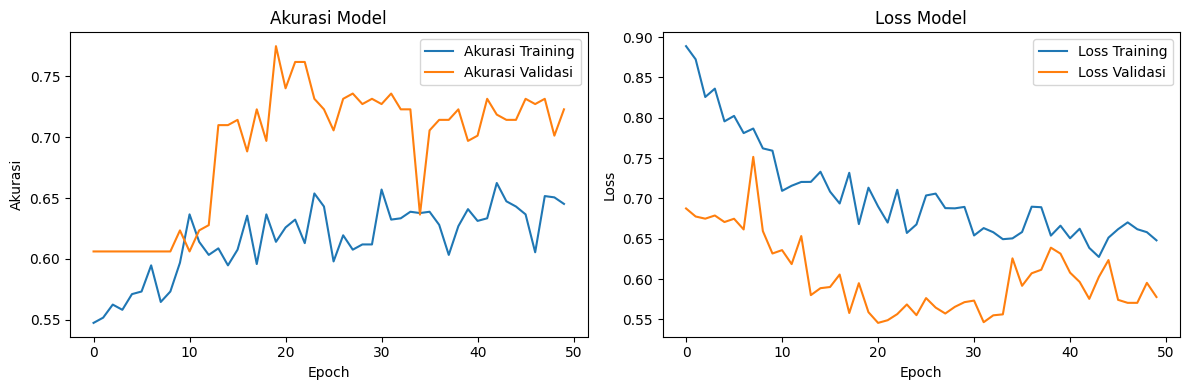

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TA/dtcpr/hasil/training_history.png')
plt.show()

In [ ]:
# Evaluasi model pada data validasi
validation_generator.reset()
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 903ms/step


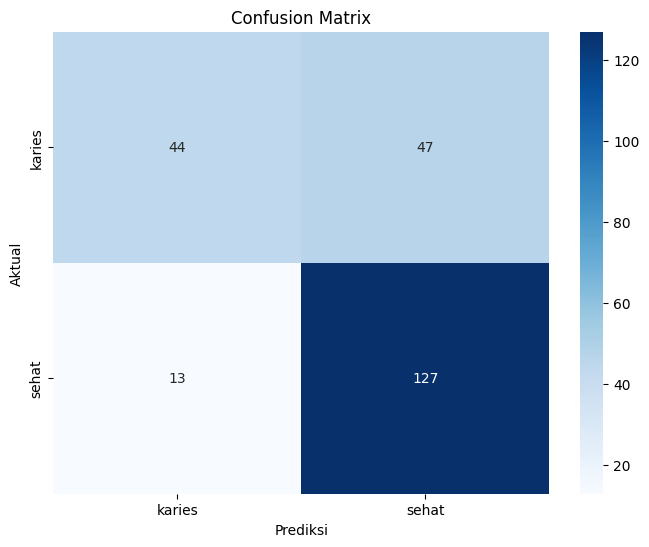

In [ ]:
# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig('/content/drive/MyDrive/TA/dtcpr/hasil/confusion_matrix.png')
plt.show()

In [ ]:
# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))


Laporan Klasifikasi:
              precision    recall  f1-score   support

      karies       0.77      0.48      0.59        91
       sehat       0.73      0.91      0.81       140

    accuracy                           0.74       231
   macro avg       0.75      0.70      0.70       231
weighted avg       0.75      0.74      0.72       231



In [ ]:
# Menyimpan model final
model.save('/content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi_final.h5')